<a href="https://colab.research.google.com/github/ucfilho/ANN/blob/master/ANN_Temporal_Series_LSTM_keras_furniture_April_13_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()

In [3]:
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable 

In [4]:
 #clonar do Github
!git clone https://github.com/OpenMindPB/Data
%cd Data

fatal: destination path 'Data' already exists and is not an empty directory.
/content/Data


In [5]:
df = pd.read_excel("Superstore.xls")
print(df.head(3)) # shows headers with top 3 rows

   Row ID        Order ID Order Date  ... Quantity Discount    Profit
0       1  CA-2016-152156 2016-11-08  ...        2      0.0   41.9136
1       2  CA-2016-152156 2016-11-08  ...        3      0.0  219.5820
2       3  CA-2016-138688 2016-06-12  ...        2      0.0    6.8714

[3 rows x 21 columns]


In [6]:
Names =df['Category'].drop_duplicates()
print(Names)

0          Furniture
2    Office Supplies
7         Technology
Name: Category, dtype: object


In [7]:
Stuff =df['Sub-Category'].drop_duplicates()
print(Stuff)

0        Bookcases
1           Chairs
2           Labels
3           Tables
4          Storage
5      Furnishings
6              Art
7           Phones
8          Binders
9       Appliances
12           Paper
26     Accessories
30       Envelopes
53       Fasteners
138       Supplies
165       Machines
335        Copiers
Name: Sub-Category, dtype: object


In [8]:
furniture = df.loc[df['Category'] == 'Furniture']
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
furniture = furniture.set_index('Order Date')
y = furniture['Sales'].resample('MS').mean()
names = y.index
y = y.reset_index()

In [9]:
import datetime
months = []
for i in names:
  months.append(i.month)

In [10]:
len(y)

48

In [11]:
y1 = y.shift(1).values[:,1]
y2 = y.shift(2).values[:,1]
y3 = y.shift(3).values[:,1]
y = y.values[:,1]

In [12]:
dataframe = pd.DataFrame({'mo':months,'t-1':y1,'t-2':y2,'t-3':y3,'y':y})
dataframe = dataframe.dropna()

In [13]:
pd.set_option("max_columns", None)
pd.set_option("max_rows", None)
dataframe.head(3)

,mo,t-1,t-2,t-3,y
3,4,857.292,367.932,480.194,567.488
4,5,567.488,857.292,367.932,432.049
5,6,432.049,567.488,857.292,695.059


In [14]:
X=dataframe.iloc[:,:-1]
y=np.array(dataframe.iloc[:,-1]).reshape(-1, 1)

In [15]:
rows, cols = X.shape
ntrain = int(rows*0.8)
X_train=X.iloc[0:ntrain,:].copy()
y_train= y[0:ntrain,:].copy()
X_test=X.drop(X_train.index)
y_test=np.delete(y,range(ntrain))
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [16]:
#, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
#X_train
scalerX = MinMaxScaler() 
scalerY = MinMaxScaler() 
scalerX.fit(X) 
scalerY.fit(y) 
X_train = scalerX.transform(X_train)
X_test = scalerX.transform(X_test)
y_train= scalerY.transform(y_train) 
y_test= scalerY.transform(y_test)

In [17]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test)) 

In [18]:
#reshaping to rows, timestamps, features
X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

In [19]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

In [20]:
num_epochs = 1000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 4 #number of features
hidden_size = 32 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

In [21]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) #our lstm class

In [22]:
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate) 

In [23]:
for epoch in range(num_epochs):
  outputs = lstm1.forward(X_train_tensors_final) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
  # obtain the loss function
  loss = criterion(outputs, y_train_tensors)
 
  loss.backward() #calculates the loss of the loss function
 
  optimizer.step() #improve from loss, i.e backprop
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Epoch: 0, loss: 0.16917
Epoch: 100, loss: 0.04082
Epoch: 200, loss: 0.02460
Epoch: 300, loss: 0.01898
Epoch: 400, loss: 0.01535
Epoch: 500, loss: 0.01157
Epoch: 600, loss: 0.00778
Epoch: 700, loss: 0.00544
Epoch: 800, loss: 0.00385
Epoch: 900, loss: 0.00244


In [24]:
X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y) 

df_X_ss = ss.transform(X) #old transformers
df_y_mm = mm.transform(y) #old transformers

df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1])) 

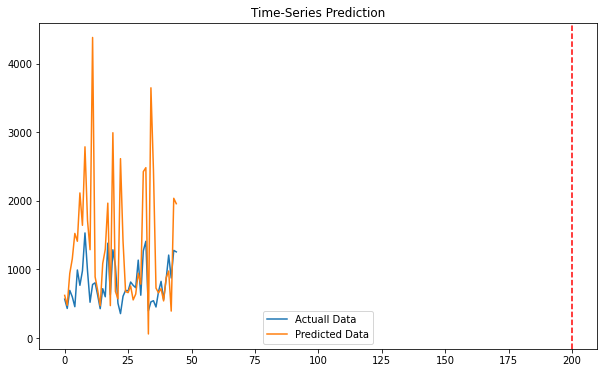

In [25]:
train_predict = lstm1(df_X_ss)#forward pass
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=200, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actuall Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

In [26]:
y_calc = y_calc_train.tolist()

NameError: ignored

In [ ]:
for yi in y_calc_test:
  y_calc.append(yi)

In [ ]:
y_calc = np.array(y_calc).reshape(1,-1)
y_calc = scalerY.inverse_transform(y_calc)

In [ ]:
line1, =plt.plot(range(len(y)),y,c='r')
line2, =plt.plot(range(len(y)),y_calc[0], c='b')
plt.legend([line1,line2],['true','ANN'],loc='upper right')
plt.show()